> ### EDA  para implementacion de modelo de recomendación de ML

**Objetivos Generales:** 
- Detectar outliers y aplicar técnicas de tratamiento de datos para asegurar la representatividad del modelo de Machine Learning.

- Identificar las características más relevantes del conjunto de datos para implementar un modelo de recomendación de Machine Learning.

- Produndizar en la comprension de las relaciones generales entre las variables del conjunto de datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import pyarrow as pa
from wordcloud import WordCloud
import gzip
import json

In [2]:
    # Ruta de los archivos Parquet
    games_parquet = 'datasets/processed_data/steam_games.parquet'
    reviews_parquet = 'datasets/processed_data/user_reviews.parquet'
    items_parquet = 'datasets/processed_data/user_items.parquet'

    # Utiliza PyArrow para leer el archivo Parquet
    tabla_games = pq.read_table(games_parquet)
    tabla_reviews = pq.read_table(reviews_parquet)
    tabla_items = pq.read_table(items_parquet)

    # Leer las tablas en DataFrames de Pandas
    steam_games = tabla_games.to_pandas()
    user_reviews = tabla_reviews.to_pandas()
    user_items = tabla_items.to_pandas()

    # Creamos copias para trabajar
    df_steam_games = steam_games.copy()
    df_user_reviews = user_reviews.copy()
    df_user_items = user_items.copy()

### Analisis
**df_user_reviews** 

Contiene "item_id", "user_id", 'recommend' (True/False) y 'sentiment_analysis' (1=negativo,0=neutro,2=positivo).

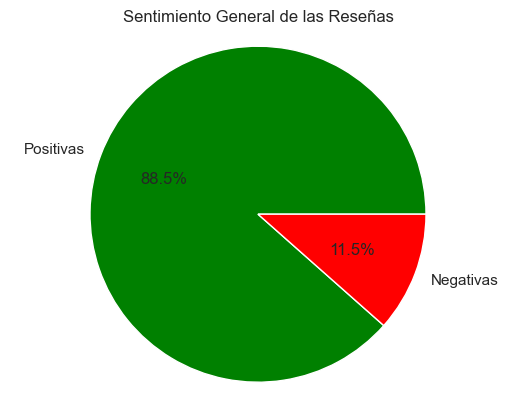

In [34]:
# Calcula la proporción de reseñas positivas y negativas
resenas_positivas = df_user_reviews[df_user_reviews['recommend'] == True]
resenas_negativas = df_user_reviews[df_user_reviews['recommend'] == False]

proporcion_positivas = len(resenas_positivas) / len(df_user_reviews)
proporcion_negativas = len(resenas_negativas) / len(df_user_reviews)

# Crea un pie chart
labels = ['Positivas', 'Negativas']
sizes = [proporcion_positivas, proporcion_negativas]
colors = ['green', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=360)
plt.title('Sentimiento General de las Reseñas')
plt.axis('equal')  
plt.show()

# Guardar item_id de las recomendaciones negativas en una lista
item_id_recomendaciones_negativas = resenas_negativas['item_id'].tolist()

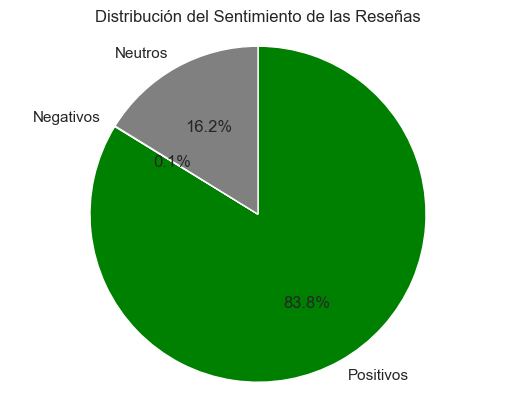

In [35]:
# Calcula la proporción de sentimientos positivos, negativos y neutros
sentimientos_positivos = df_user_reviews[df_user_reviews['sentiment_analysis'] == 2]
sentimientos_negativos = df_user_reviews[df_user_reviews['sentiment_analysis'] == 1]
sentimientos_neutros = df_user_reviews[df_user_reviews['sentiment_analysis'] == 0]

proporcion_positivos = len(sentimientos_positivos) / len(df_user_reviews)
proporcion_negativos = len(sentimientos_negativos) / len(df_user_reviews)
proporcion_neutros = len(sentimientos_neutros) / len(df_user_reviews)

# Crea un pie chart con los sentimientos positivos, negativos y neutros
labels = ['Positivos', 'Negativos', 'Neutros']
sizes = [proporcion_positivos, proporcion_negativos, proporcion_neutros]
colors = ['green', 'red', 'gray']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribución del Sentimiento de las Reseñas')
plt.axis('equal')  
plt.show()

In [41]:
# Eliminar items que coinciden con item_id_recomendaciones_negativas
df_user_items = df_user_items[~df_user_items['item_id'].isin(item_id_recomendaciones_negativas)]

> conclusion

No parece existir una proporcion significativa de reseñas negativas ni en la columna "recommend" ni en "sentiment_analysis" por tanto descartaremos el df_user_reviews para implementar el modelo.
Sin embargo utilizamremos estos datos para eliminar los items que corresponden a recomencaiones negativas en df_user_items bajo el supuesto de que aquellos items que no son recomendados por los propios usuarios no deberias ser recomendados por el sistema de recomendacion.

### Analisis

**df_user_items** 

Registra el 'playtime_forever' de los 'user_id' para cada 'item_id'.


In [42]:
# Distribución del tiempo jugado
df_user_items['playtime_forever'].describe()

count    887826.000000
mean        400.271339
std         876.822445
min           1.000000
25%          23.000000
50%         109.000000
75%         343.000000
max        8271.000000
Name: playtime_forever, dtype: float64

Identificacion de outliers

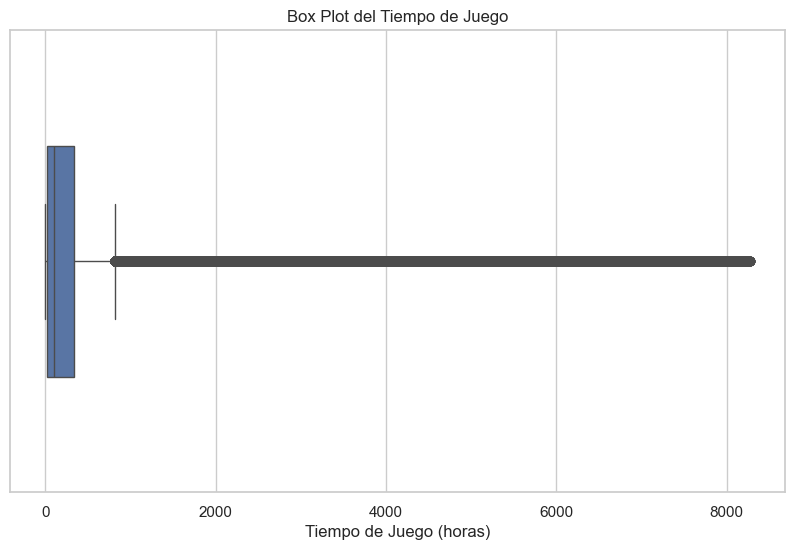

In [43]:
# Crear un box plot para el tiempo de juego
plt.figure(figsize=(10, 6))
sns.boxplot(x='playtime_forever', data=df_user_items, width=0.5)
plt.title('Box Plot del Tiempo de Juego')
plt.xlabel('Tiempo de Juego (horas)')
plt.show()

Tratamieto de outliers

In [44]:
# Calcular la media y la desviación estándar
mean_valor = df_user_items['playtime_forever'].mean()
std_valor = df_user_items['playtime_forever'].std()

# Definir el umbral para considerar outliers (por ejemplo, 4 desviaciones estándar)
threshold = 1

# Filtrar los outliers
df_user_items = df_user_items[(df_user_items['playtime_forever'] >= mean_valor - threshold * std_valor) & 
                              (df_user_items['playtime_forever'] <= mean_valor + threshold * std_valor)]

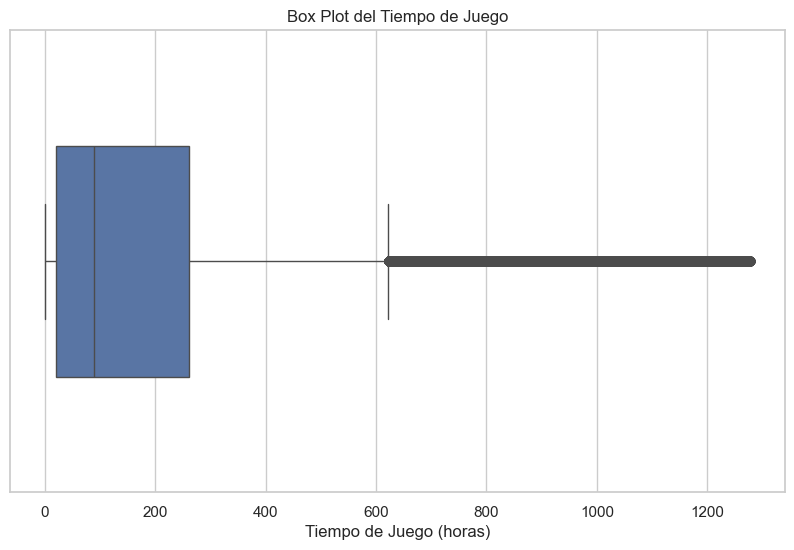

In [45]:
# Crear un box plot para el tiempo de juego
plt.figure(figsize=(10, 6))
sns.boxplot(x='playtime_forever', data=df_user_items, width=0.5)
plt.title('Box Plot del Tiempo de Juego')
plt.xlabel('Tiempo de Juego (horas)')
plt.show()

In [46]:
porcentaje_elimindos = ((len(user_items) - len(df_user_items)) / len(user_items)) * 100

print(f"Se eliminó el {porcentaje_elimindos:.2f}% de los datos como outliers")

Se eliminó el 74.72% de los datos como outliers


> Conclusion

En la distribucion el rango intercuartílico (IQR) se mantiene en valores bajos, lo que indica que la mayor concentración de datos sigue estando en este rango. La desviación estándar alta indica una alta variabilidad en el tiempo de juego, lo que sumado a lo anterior confirma la presencia de valores muy atípicos en la distribucion. Los valoas atipicos indican que existen algunos jugadores con cantidad de horas de juego considerablemente altas en comparacion a la gran mayoria.

Tomaremos la decicion de eiminar outliers para mejorar la capacidad de generalización del modelo, ya que evita que el modelo se ajuste demasiado a patrones extremos que podrían no representar bien el comportamiento general de los datos.

Por otro lado, veremos que el playtime_forever podria ser un indicador plausible de ser utilizado para el modelo de recomendacion, bajo el supuesto de que mayor cantidad de horas en un juego indica mayor preferencia por parte de los usuarios.

### Analisis

**df_steam_games** 

Contiene "title", "item_id","release_year", "price", "developer" y "genres".


> Visto y considerando que la columna genres contiene informacion plasible de ser utilizada en el sistema de recomendacion, ya que contiene caracteristicas intrinsecas de el tipo de item que cosumen los usuarios, vamos a crear una tabla llamada genres que corresponde a cada genero como columna, el item id como indice y un 1 o un 0 si el item contiene o no contiene dicho genero (variables dummy).

In [69]:
# Vamos trabajar para desanidar genres y exportarlo en un parquet difente.

# Lista para almacenar diccionarios creados a partir de cada línea
lista_steam_games = []

# Ruta del archivo comprimido en modo lectura
archivo_comprimido_steam_games = 'datasets/raw_data/steam_games.json.gz'

# Abrir el archivo comprimido y procesar cada línea
with gzip.open(archivo_comprimido_steam_games, 'rt', encoding='utf-8') as archivo_steam_games:
    for linea in archivo_steam_games:
        try:
            # Utilizar json.loads para convertir cada línea en un diccionario
            json_data = json.loads(linea)
            lista_steam_games.append(json_data)
        except json.JSONDecodeError as e:
            # Manejar errores al intentar decodificar la línea como un diccionario JSON
            print(f"Error en la línea: {linea}")
            continue

In [70]:
# Usamos json_normalize para extraer la informacion anindada en la columna 'generes'

genres = pd.json_normalize(
    data=lista_steam_games, # datos de origen en formato no serializado
    record_path='genres', # ruta de datos anidados
    meta=['id' ] # campos que se quieren corsevar
)

In [71]:
genres

,0,id
0,Action,761140
1,Casual,761140
2,Indie,761140
3,Simulation,761140
4,Strategy,761140
...,...,...
71549,Indie,610660
71550,Racing,610660
71551,Simulation,610660
71552,Casual,658870


In [73]:
# Eliminamos nulos
genres.dropna(inplace=True) 

# Colocamos item_id correctamente
genres = genres.rename(columns={'id': 'item_id'})

# le asignamos el nombre genero a la columna desanidada
genres.columns.values[0] = 'genres'

# Establecer la columna item_id como el índice del DataFrame
genres.set_index('item_id', inplace=True)

In [74]:
genres

,genres
item_id,
761140,Action
761140,Casual
761140,Indie
761140,Simulation
761140,Strategy
...,...
610660,Indie
610660,Racing
610660,Simulation


In [75]:
# Aplicar get_dummies para crear variables dummy
dummy_genres = pd.get_dummies(genres['genres'])

# Concatenar las variables dummy al DataFrame original
genres = pd.concat([genres, dummy_genres], axis=1)

# Eliminar la columna 'genres' original 
genres = genres.drop('genres', axis=1)

# Agrupar por 'item_id' y sumar las variables dummy
genres = genres.groupby('item_id').sum()

# Convertir valores mayores que 1 a 1
genres[genres > 1] = 1


In [76]:
genres

,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,Education,Free to Play,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
item_id,,,,,,,,,,,,,,,,,,,,,
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100400,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10090,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100980,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99700,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9980,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99900,0,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


#### Vamos a exportar e importar nuevamente genres para trabajar con el nuevo dataset.

In [80]:
# Exportamos
genres.to_parquet("datasets/processed_data/ml_genres.parquet")

# Importamos 
genres_parquet = "datasets/processed_data/ml_genres.parquet"
tabla_genres = pq.read_table(genres_parquet)
df_genres = tabla_genres.to_pandas()

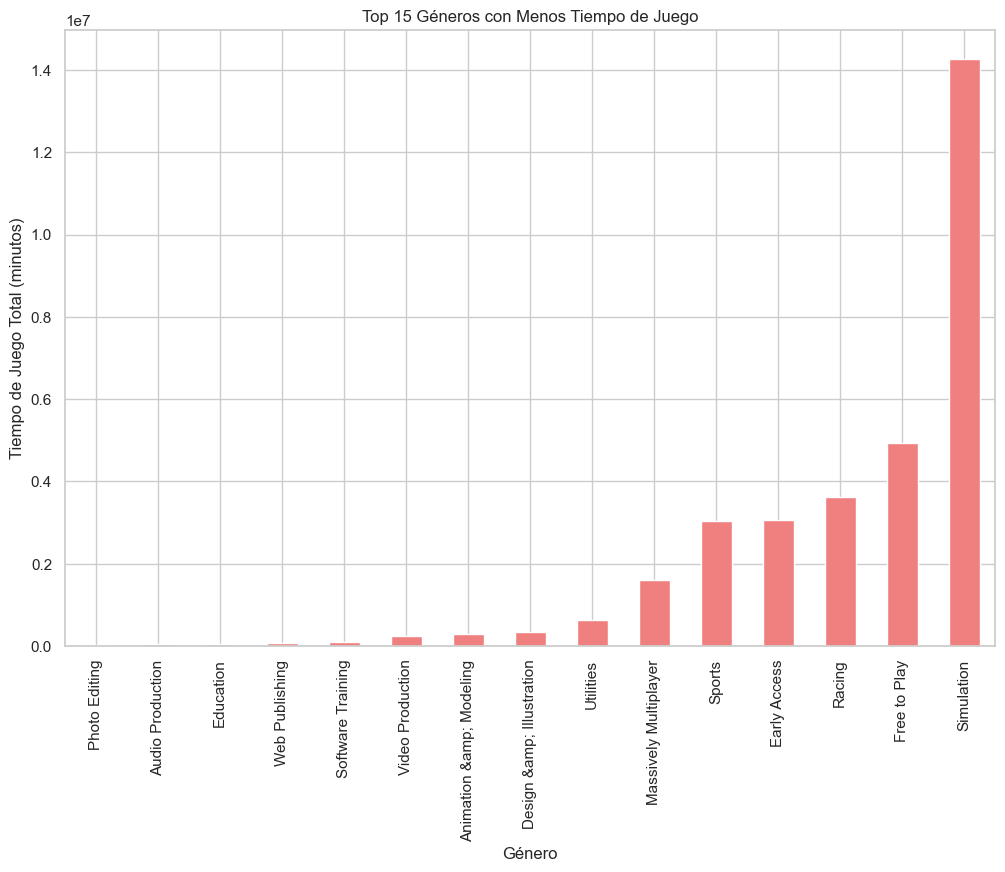

In [81]:
# Fusionar los conjuntos de datos df_genres y df_user_items
merged_df = pd.merge(df_genres, df_user_items, on='item_id')

# Multiplicar la columna playtime_forever por el género correspondiente
for genre in df_genres.columns[1:]:
    merged_df[genre] = merged_df[genre] * merged_df['playtime_forever']

# Sumar el tiempo de juego para cada género
genre_playtime_sum = merged_df.groupby('user_id')[[genre for genre in df_genres.columns[1:]]].sum()

# Calcular el total de tiempo de juego por género
total_playtime_per_genre = genre_playtime_sum.sum()

# Seleccionar los 15 géneros con menos tiempo de juego
bottom_15_genres = total_playtime_per_genre.sort_values(ascending=True).head(15)

# Crear un gráfico de barras para los 15 géneros con menos tiempo de juego
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  

bottom_15_genres.plot(kind='bar', color='lightcoral')
plt.title('Top 15 Géneros con Menos Tiempo de Juego')
plt.xlabel('Género')
plt.ylabel('Tiempo de Juego Total (minutos)')

plt.show()

bottom_15_genres_list = bottom_15_genres.index.tolist()

In [84]:
# Vamos a eliminar todos aquellos juegos que pertenezcan a los juegos menos jugados del playtime
# bottom_15_genres_list

# Fusionar los conjuntos de datos df_genres y df_user_items
merged_df = pd.merge(df_genres, df_user_items, on='item_id')

# Eliminar juegos que pertenecen a los géneros de bottom_15_genres_list
df_user_items = merged_df[~merged_df[bottom_15_genres_list].any(axis=1)]

# Puedes seleccionar solo las columnas necesarias si lo deseas
df_user_items = df_user_items[['user_id', 'item_id', 'playtime_forever']]

# Ahora, df_user_items contiene solo los juegos que no pertenecen a los géneros de bottom_15_genres_list

Ahora estamos en condiciones de exportar los datos con los datos limpios con aquellas posibles caracteristicas de interes para nuestro modelo de recomendacion, vamos a proseguir con el EDA a la vez que implmentamos dicho modelo con el objetivo de volver, de ser necesario, en un proceso iterativo, a volvar la informacion del EDA en el modelo a implementar.

In [86]:
# Exportamos
df_user_items.to_parquet("datasets/processed_data/ml_user_items.parquet")



> ### Produndizacion en la comprension de las relaciones generales entre las variables
